In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector

In [6]:
df = datasets.load_iris()
dff = datasets.load_iris()
dff = pd.DataFrame(data=np.c_[dff['data'], dff['target']], columns=dff['feature_names'] + ['target'])
df = pd.DataFrame(data=np.c_[df['data'], df['target']], columns=df['feature_names'] + ['target'])
df_columns = df.columns.values[:-1] 
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [7]:
x_train, x_test, y_train, y_test = train_test_split(df[df_columns], df['target'], test_size=0.30, random_state=0, stratify=df['target'])
x_val, x_test, y_val, y_test = train_test_split(x_train, y_train, test_size=0.5, random_state=0, stratify=y_train)

y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(target
 2.0    35
 0.0    35
 1.0    35
 Name: count, dtype: int64,
 target
 2.0    18
 1.0    17
 0.0    17
 Name: count, dtype: int64,
 target
 0.0    18
 1.0    18
 2.0    17
 Name: count, dtype: int64)

In [8]:
dff[dff.duplicated(keep=False)]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
101,5.8,2.7,5.1,1.9,2.0
142,5.8,2.7,5.1,1.9,2.0


In [9]:
dff.drop_duplicates(inplace=True)

# Preprocessing

In this project we decided that we will use ``angle encoding`` because we don't have that many quibits to work with. Since angle enncoding needs the data to be on a scale between $[0, 2\pi]$, we will scale the data accordingly

In [10]:
# custom transformers for the pipeline
class RemoveDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = pd.DataFrame(X)
        df = df.drop_duplicates()
        return df.values

In [11]:
scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
remove_duplicates = RemoveDuplicates()

pipe = Pipeline([
    ('scaler', scaler),
    ('remove_duplicates', remove_duplicates)
])

In [12]:
x_train = pipe.fit_transform(x_train)
x_val = pipe.transform(x_val)
x_test = pipe.transform(x_test)

# choosing a loss function

In [13]:
class IrisQNN:
    def __init__(self, n_qubits, n_layers):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_params = n_qubits * n_layers
        self.params = ParameterVector('θ', self.n_params)
    
    def angle_encoding(self, qc, input_features):
        number_of_qubits = qc.num_qubits
        for qubit in range(number_of_qubits):
            qc.rx(input_features[qubit], qubit)
        qc.barrier()
        return qc

    def add_variational_layer_real_amplitude(self, qc, layer_idx):
        param_offset = layer_idx * self.n_qubits
        for i in range(self.n_qubits):
            qc.ry(self.params[param_offset + i], i)
        
        qc.barrier()
        
        for i in range(self.n_qubits - 1):
            qc.cx(i, i+1)
            
        if layer_idx < self.n_layers - 1:
            qc.barrier()
            
        return qc

    def create_circuit(self, input_features, variational_params=None):
        qc = QuantumCircuit(self.n_qubits)
        
        self.angle_encoding(qc, input_features)
        
        for layer in range(self.n_layers):
            self.add_variational_layer_real_amplitude(qc, layer)
        
        if variational_params is not None:
            qc.bind_parameters({self.params: variational_params})

        return qc
    
    def _get_parameter_count(self):
        return self.n_params

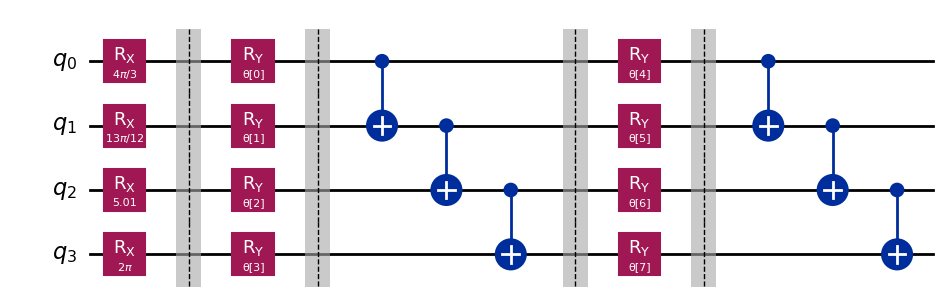

In [14]:
qnn = IrisQNN(n_qubits=4, n_layers=2)
feature = x_train[0]
qc = qnn.create_circuit(feature)
qc.draw('mpl')

In [16]:
def multiClassCrossEntropy(prediction, label):
    return -(label * np.log(prediction))

def split_into_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

def finiteDifference(lossFunction, params, paramIndex, epsilon, *args):
    forward = np.array(params, copy=True)
    backward = np.array(params, copy=True)
    forward[paramIndex] += epsilon
    backward[paramIndex] -= epsilon
    forward_loss = lossFunction(forward, *args)
    backward_loss = lossFunction(backward, *args)
    gradient = (forward_loss - backward_loss) / (2 * epsilon)
    return gradient

def execute_circuits(quantum_circuits, backend, shots=1000):
    for qc in quantum_circuits:
        qc.measure_all()
    transpiled_qcs = transpile(quantum_circuits, backend)
    job = backend.run(transpiled_qcs, shots=shots)
    return job.result().get_counts()

In [18]:
qc = QuantumCircuit(4)
qc2 = QuantumCircuit(4)
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.cx(0, 1)
qc.rx(0, 0)
qc.rx(1, 1)
qc.rx(1, 3)


qc2.h(0)
qc2.h(1)
qc2.rx(0, 0)

res = execute_circuits([qc, qc2], QasmSimulator(), shots=1000)
res

[{'1010': 61,
  '0010': 63,
  '0000': 60,
  '0101': 61,
  '0001': 67,
  '0011': 61,
  '0111': 75,
  '1101': 72,
  '1111': 57,
  '0110': 62,
  '1110': 49,
  '1000': 56,
  '0100': 52,
  '1100': 64,
  '1001': 66,
  '1011': 74},
 {'0001': 248, '0000': 257, '0011': 255, '0010': 240}]

In [ ]:
epochs = 2
x_train_sub = x_train[:10]

for epoch in range(epochs):
    for batch in split_into_batches(x_train_sub, batch_size=1):
        
    

TypeError: 'generator' object is not subscriptable

In [17]:
#TODO Implent funciton for initialising the weights
#TODO Implement funciton for creating circuits for all the training data
#TODO implement function for calculating the cost function